# Two-dimensional double-well system

In this notebook we explore two particles in a two-dimensional double-well system. We parameterize the double-well by the absolute barrier potential given by
\begin{align}
    \hat{v}(\mathbf{r}) = \frac{1}{2} \omega^2 \left[
        \hat{r}^2
        + \frac{1}{4} R^2
        - R|\hat{x}|,
    \right]
\end{align}
where $R$ is the distance between the two wells.

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

from quantum_systems import BasisSet, GeneralOrbitalSystem, ODQD
from configuration_interaction import CISD
from hartree_fock import GHF

from gaussians import G2D
from gaussians.two_dim import construct_arbitrary_separable_potential_elements

import gaussians.two_dim_lib as tdl

<IPython.core.display.Javascript object>

In [3]:
# Used by Jørgen Høgberget in his master's thesis
R = 2
omega = 1
center_l = (-R / 2, 0)
center_r = (R / 2, 0)

x = np.linspace(-4, 4, 401)
y = x[:]

X, Y = np.meshgrid(x, y)

<IPython.core.display.Javascript object>

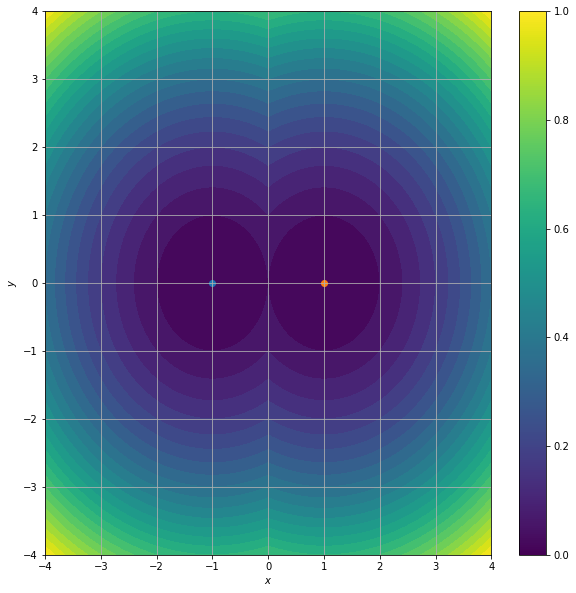

<IPython.core.display.Javascript object>

In [4]:
pot_x = ODQD.DWPotential(omega=omega, l=R)
pot_y = ODQD.HOPotential(omega=omega)

fig = plt.figure(figsize=(10, 10))

plt.contourf(X, Y, pot_x(X) + pot_y(Y), 25)
plt.scatter(*center_l)
plt.scatter(*center_r)
plt.colorbar()
plt.grid()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

In [5]:
ang_mom = [(0, 0), (0, 1), (1, 0), (0, 2), (1, 1), (2, 0)]
# ang_mom = [(0, 0)]

gaussians = [G2D(ij, omega / 2, center_l) for ij in ang_mom] + [
    G2D(ij, omega / 2, center_r) for ij in ang_mom
]

g_params = [g.get_params() for g in gaussians]

<IPython.core.display.Javascript object>

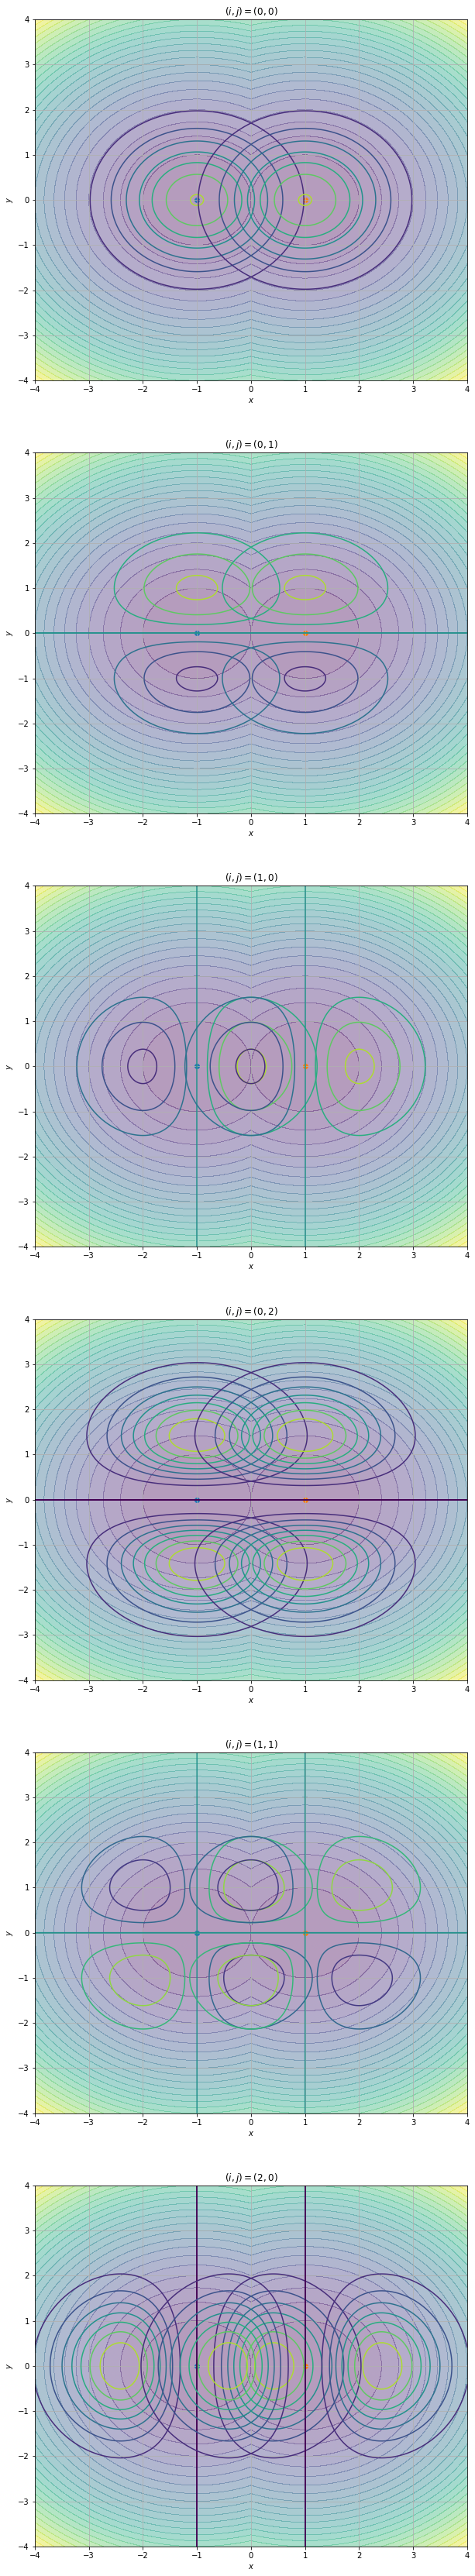

<IPython.core.display.Javascript object>

In [6]:
fig, axes = plt.subplots(len(ang_mom), figsize=(10, len(ang_mom) * 10))
# axes = [axes]
ax_ind = 0
for gauss_l, gauss_r in zip(
    gaussians[: len(ang_mom)], gaussians[len(ang_mom) :]
):
    axes[ax_ind].contourf(X, Y, pot_x(X) + pot_y(Y), 25, alpha=0.4)
    axes[ax_ind].scatter(*center_l)
    axes[ax_ind].scatter(*center_r)

    axes[ax_ind].contour(X, Y, gauss_l(X, Y, with_norm=True))
    axes[ax_ind].contour(X, Y, gauss_r(X, Y, with_norm=True))
    axes[ax_ind].set_title(rf"$(i, j) = {gauss_l.alpha}$")
    ax_ind += 1

for ax in axes:
    ax.grid()
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

plt.show()

In [7]:
v_num = construct_arbitrary_separable_potential_elements(
    pot_x,
    pot_y,
    gaussians,
    x,
    y,
)

<IPython.core.display.Javascript object>

In [8]:
v_ho_x = (
    0.5
    * omega**2
    * tdl.construct_multipole_moment_matrix_elements((2, 0), (0, 0), g_params)
)
v_ho_y = (
    0.5
    * omega**2
    * tdl.construct_multipole_moment_matrix_elements((0, 2), (0, 0), g_params)
)
v_abs_num = (
    -0.5
    * omega**2
    * R
    * construct_arbitrary_separable_potential_elements(
        lambda x: np.abs(x),
        lambda x: 1,
        gaussians,
        x,
        y,
    )
)

v_const = (
    0.5
    * omega**2
    * 0.25
    * R**2
    * tdl.construct_overlap_matrix_elements(g_params)
)

<IPython.core.display.Javascript object>

In [9]:
v = v_ho_x + v_ho_y + v_abs_num + v_const

<IPython.core.display.Javascript object>

In [10]:
t = tdl.construct_kinetic_operator_matrix_elements(g_params)
s = tdl.construct_overlap_matrix_elements(g_params)

<IPython.core.display.Javascript object>

In [11]:
u = tdl.construct_coulomb_operator_matrix_elements(g_params)

<IPython.core.display.Javascript object>

In [12]:
h = t + v

<IPython.core.display.Javascript object>

In [13]:
bs = BasisSet(len(gaussians), dim=2)
bs.h = h
bs.s = s
bs.u = u

bs.spf = np.asarray([gauss(X, Y, with_norm=True) for gauss in gaussians])

<IPython.core.display.Javascript object>

In [14]:
eps, C = scipy.linalg.eigh(bs.h, bs.s)

<IPython.core.display.Javascript object>

In [15]:
bs.change_basis(C)

<IPython.core.display.Javascript object>

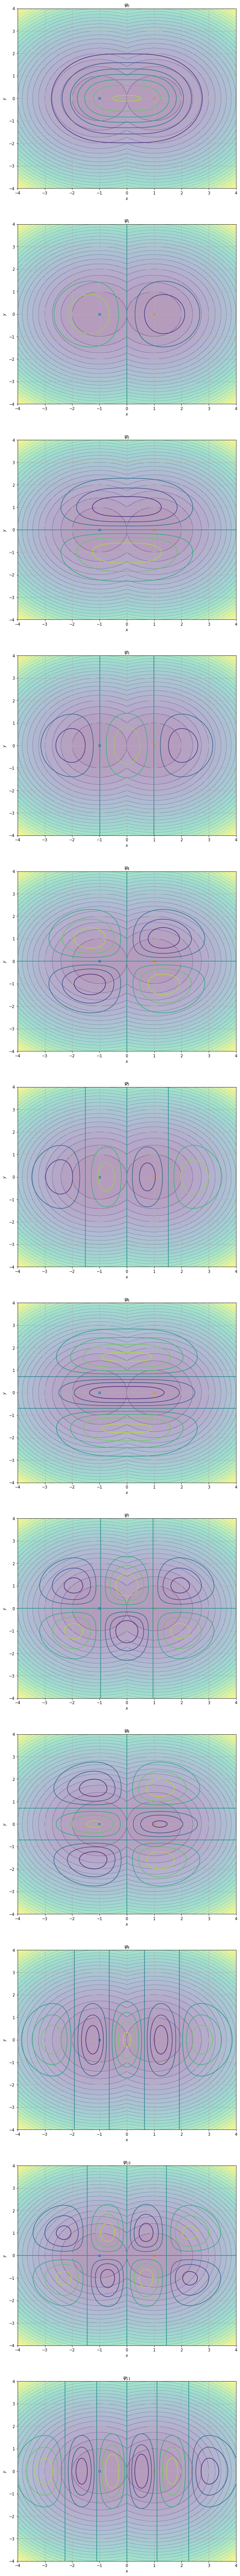

<IPython.core.display.Javascript object>

In [16]:
fig, axes = plt.subplots(bs.l, figsize=(10, bs.l * 10))

ax_ind = 0
for i in range(bs.l):
    axes[ax_ind].contourf(X, Y, pot_x(X) + pot_y(Y), 25, alpha=0.4)
    axes[ax_ind].scatter(*center_l)
    axes[ax_ind].scatter(*center_r)

    axes[ax_ind].contour(X, Y, bs.spf[i])
    axes[ax_ind].set_title(r"$\psi_{" + rf"{i}" + r"}$")
    ax_ind += 1

for ax in axes:
    ax.grid()
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

plt.show()

In [17]:
gos = GeneralOrbitalSystem(2, bs)

<IPython.core.display.Javascript object>

In [18]:
ghf = GHF(gos.copy_system(), verbose=True).compute_ground_state()

converged=False, total_energy=(2.6138244509443807+0j), iterations=1
converged=False, total_energy=(2.5513732950956127+0j), iterations=2
converged=False, total_energy=(2.551170949655747+0j), iterations=3
converged=True, total_energy=(2.5511689344912813+0j), iterations=4
Changing system basis...
Changing to GHF basis
Final GHF energy: (2.5511689344912813+0j)


<IPython.core.display.Javascript object>

In [19]:
cisd = CISD(gos, verbose=True).compute_ground_state()

Number of states to create: 276
Size of a state in bytes: 8
Time spent setting up CISD space: 0.3147428035736084 sec
Time spent constructing one-body Hamiltonian: 2.8973398208618164 sec
Time spent constructing two-body Hamiltonian: 5.400401830673218 sec
Time spent constructing S_z: 0.009536981582641602 sec
Time spent constructing S^2: 0.053936004638671875 sec
Time spent diagonalizing Hamiltonian: 0.07653498649597168 sec
CISD ground state energy: 2.3594056965476558


<IPython.core.display.Javascript object>

Time spent computing one-body matrix: 0.033701181411743164 sec
S^2(0) = -0.0
Time spent computing one-body matrix: 0.02120184898376465 sec
S^2(1) = 2.0
Time spent computing one-body matrix: 0.021752119064331055 sec
S^2(2) = 2.0
Time spent computing one-body matrix: 0.022039175033569336 sec
S^2(3) = 2.0
Time spent computing one-body matrix: 0.02163410186767578 sec
S^2(4) = -0.0
Time spent computing one-body matrix: 0.02204608917236328 sec
S^2(5) = 2.0
Time spent computing one-body matrix: 0.021625757217407227 sec
S^2(6) = 2.0
Time spent computing one-body matrix: 0.021503925323486328 sec
S^2(7) = 2.0
Time spent computing one-body matrix: 0.022839784622192383 sec
S^2(8) = -0.0
Time spent computing one-body matrix: 0.021900177001953125 sec
S^2(9) = 2.0


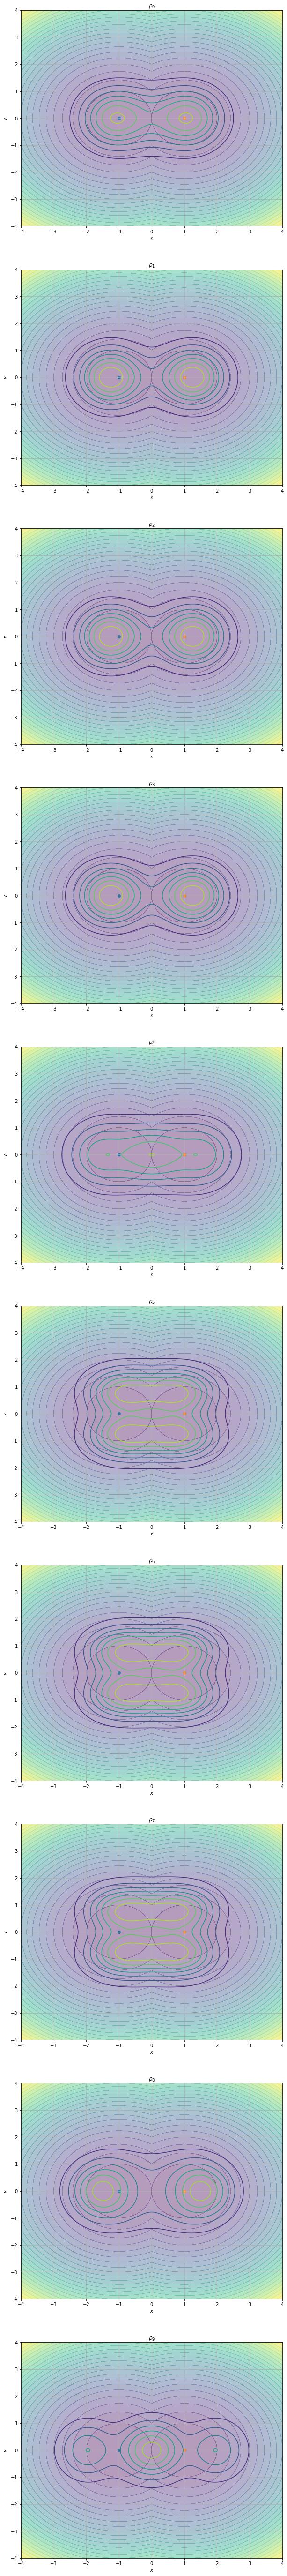

<IPython.core.display.Javascript object>

In [20]:
num_states = 10

fig, axes = plt.subplots(num_states, figsize=(10, num_states * 10))

ax_ind = 0
for I in range(num_states):
    axes[ax_ind].contourf(X, Y, pot_x(X) + pot_y(Y), 25, alpha=0.4)
    axes[ax_ind].scatter(*center_l)
    axes[ax_ind].scatter(*center_r)

    axes[ax_ind].contour(X, Y, cisd.compute_particle_density(K=I).real)
    axes[ax_ind].set_title(r"$\rho_{" + rf"{I}" + r"}$")
    print(rf"S^2({I}) = {np.round(cisd._s_2[I], 10)}")
    ax_ind += 1

for ax in axes:
    ax.grid()
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")

plt.show()